In [ ]:
from PIL import Image
import numpy as np
import math
import torch
print(torch.__version__)

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

1.9.0+cu102


## Modeling

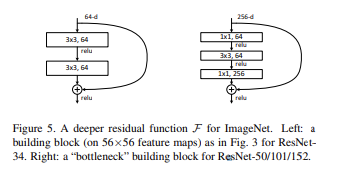

In [ ]:
# 왜? bottleneck을 사용할까? => 그림에서 볼 수 있듯이  3 x 3 conv 앞 뒤에 1 x 1 conv를 사용해 파라미터를 줄일 수 있기 때문이다!
class bottleneck(nn.Module):
  def __init__(self, start_dim ,mid_dim, end_dim , stride):
    super(bottleneck, self).__init__()
    # 이 구조는 residual function( F(x) )와 identity( x )를 사용합니다. (이렇게 해서 기울기 소실 문제 해결!)

    # F(x)의 구조
    ## 위의 구조를 그대로 옮긴 상태입니다.
    self.residual = nn.Sequential(
        nn.Conv2d(start_dim, mid_dim, kernel_size=1, stride=stride, padding=0, bias=False),
        nn.BatchNorm2d(mid_dim),
        nn.ReLU(),
        nn.Conv2d(mid_dim, mid_dim, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(mid_dim),
        nn.ReLU(),
        nn.Conv2d(mid_dim, end_dim, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(end_dim)
    )

    # identity x 구조(stride가 1이 아니면 size가 변화한 것이 있으므로 identity도 그에 따라 바꿔줘야 합니다.)
    # skip/short connection을 추가하기 위해서는 더해지는 값 ( identity x )와 출력값의 차원이 같아야 합니다.
    self.shortcut = nn.Sequential()
    self.shortcut = nn.Sequential(
        nn.Conv2d(start_dim,end_dim,kernel_size=1,stride=stride,bias=False),
        nn.BatchNorm2d(end_dim)
    )
    
    
    # F(x)와 x를 더할 때 쓰는 활성화 함수
    self.relu = nn.ReLU()
  
  def forward(self,x):
    x = self.residual(x) + self.shortcut(x)
    x = self.relu(x)
    return x

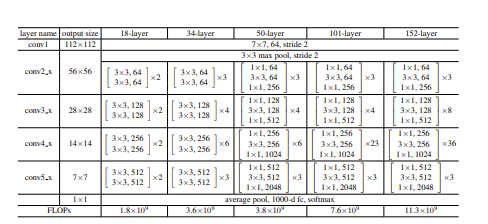

위의 사진 중에 50-layer를 구현하고자 한다.

In [ ]:
class ResNet(nn.Module):
  # num_class는 데이터 class 개수에 따라 달라진다.
  def __init__(self, perlayer, residualblock, num_class=100):
    super(ResNet, self).__init__()
    self.num_class = num_class
    # Batch normalization이 convolution 뒤에 일어난다!
    # conv1 부분
    ## 우선 입력 차원은 3이고 논문에서 out 차원은 64, kernel_size은 7, stride는 2
    ##  padding은 맘대로인 것 같습니다.(각자 원하는 대로~)
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        ## 위의 논문에서는 3 x 3 max pool, stride 2를 쓴다고 하여 적용했습니다!
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )
    # conv1이 끝나면 여기서 224x224x3 image가 56x56x64 image로 변환
    
    # 2번째 layer ~ 5번째 layer
    start_dim=64
    # conv1에서 56 x 56 x 64 output size를 만들었기에 conv2 결과 output size도 56 x 56이면 되므로 stride를 1로 하여 size를 줄이지 않는다.
    self.conv2 = self.get_layers(residualblock,start_dim,start_dim,start_dim*4,perlayer[0],1)

    # conv2에서 56 x 56 x 256 output size를 만들었기에 conv3 결과 output size는 28 x 28로 되야하므로 stride를 2로 하여 size를 줄인다. 
    self.conv3 = self.get_layers(residualblock,start_dim*4,start_dim*2,start_dim*8,perlayer[1],2)

    # conv3에서 28 x 28 x 512 output size를 만들었기에 conv4 결과 output size는 14 x 14로 되야하므로 stride를 2로 하여 size를 줄인다. 
    self.conv4 = self.get_layers(residualblock,start_dim*8,start_dim*4,start_dim*16,perlayer[2],2)

    # conv4에서 14 x 14 x 1024 output size를 만들었기에 conv5 결과 output size는 7 x 7로 되야하므로 stride를 2로 하여 size를 줄인다. 
    self.conv5 = self.get_layers(residualblock,start_dim*16,start_dim*8,start_dim*32,perlayer[3],2)

    # 논문에서는 "The network ends with a global average pooling" 문구로 globalaveragepooling2d를 쓰고자한다.
    # Global Average Pooling Layer는 TF2에서는 tf.keras.layers.GlobalAveragePooling2D로 쓰이고
    # PyTorch에서 torch.nn.AdaptiveAvgPool2d(output size) 사용된다.
    self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # output은 위의 논문에서 1 x 1이므로 

    # 마지막 layer가 위의 논문에서 볼 수 있듯이 2048이므로 입력을 2048로 하고 구하고자 하는 class 개수를 output으로 한다.
    self.fc_out = nn.Linear(2048, num_class)

    # 각 weight 초기화 하기
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        # 초기화로 비선형일 때, relu와 mode = 'fan_out'으로 backwards 통과 가중치 유지시킨다.
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None: 
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        # bachnorm2d 파라미터 초기화
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

  def get_layers(self, residualblock, start_dim, mid_dim, end_dim, repeats, stride):
    layers = []
    layers.append(residualblock(start_dim,mid_dim,end_dim,stride))
    for _ in range(0,repeats-1):
      layers.append(residualblock(end_dim,mid_dim,end_dim,1))
    # layer 쌓은 것 합치기
    return nn.Sequential(*layers)

  def forward(self, x):
    # 위의 논문 구조로 나열하기
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avgpool(x)
    # 2048 x 1 -> 1 x 2048로 변경!
    x = x.view(x.size(0), -1)
    x = self.fc_out(x)
    return x

In [ ]:
def resnet50():
    return ResNet([3,4,6,3],bottleneck)

In [ ]:
import gc 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)

In [ ]:
# 우선 논문 중에 "A 224×224 crop is randomly sampled from an image or itshorizontal flip, with the per-pixel mean subtracted " 부분으로 인해
# 대략 3 x 3 x 224 x 224 사이즈 임의의 수를 넣으면 어떤 크기가 나오는지 보자!
x = torch.randn(3, 3, 224, 224).to(device)
x = model(x)
print(x.size())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([3, 100])


In [ ]:
x = torch.randn(3, 3, 224, 224).to(device)
x.shape

torch.Size([3, 3, 224, 224])

In [ ]:
# Optimize
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9,weight_decay=0.0005)

In [ ]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)
loss_fn = nn.CrossEntropyLoss().to(device)

# Dataset

In [ ]:
# Normalize training set together with augmentation
import torchvision
import torchvision.transforms as transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
    transforms.Resize((224,224))
])

# Normalize test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
    transforms.Resize((224,224))
])

In [ ]:
trainset = torchvision.datasets.CIFAR100(root="/data",
                                         train=True,
                                         download=True,
                                         transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR100(root="/data",
                                        train=False,
                                        download=True,
                                        transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Train 및 Test

In [ ]:
def train(epoch, global_steps):
    model.train()

    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        global_steps += 1
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        del inputs
        del targets
        del outputs

    acc = 100 * correct / total
    print('train epoch : {} [{}/{}]| loss: {:.3f} | acc: {:.3f}'.format(
        epoch, batch_idx, len(trainloader), train_loss / (batch_idx + 1), acc))
    return global_steps

In [ ]:
def test(epoch, best_acc, global_steps):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            del inputs
            del targets
            del outputs

    acc = 100 * correct / total
    print('test epoch : {} [{}/{}]| loss: {:.3f} | acc: {:.3f}'.format(
        epoch, batch_idx, len(testloader), test_loss / (batch_idx + 1), acc))
    
    if acc > best_acc:
        best_acc = acc

    return best_acc

In [ ]:
#args = parser.parse_args()
if __name__ == '__main__':
    best_acc = 0
    epoch = 0
    global_steps = 0
    while True:
            epoch += 1
            global_steps = train(epoch, global_steps)
            best_acc = test(epoch, best_acc, global_steps)
            print('best test accuracy is ', best_acc)

            if global_steps >= 64000:
                break

KeyboardInterrupt: ignored

제가 resize(224,224)를 안 했을 때는 epoch 30과 40 사이에, test_loss는 1.9에서 돌았고 test_accuracy는 0.38~0.40에서 돌았습니다!! (이 때, batchsize를 256으로 했습니다.)

제가 resize(224,224)를 추가해서 돌리느라 원래 결과는 날라갔는데 추가하니 시간이 엄청 걸려서 우선 코드를 보여주기 위한 목적이므로 올려드립니다! 죄송합니다 ㅠㅠ
(그 전에 돌린 코드와 차이점은 resize(224,224) 추가와 메모리 때문에 batchsize를 64로 지정하고 시도했습니다.) 